In [1]:
#written 1.17.24 by @caramnix (last udpdated 1.25)

#goal: have a single csv for each congress with the following columns 
#Tweet- date- icpsr- member name - party - female - black - cleaned text- sentiment score 

# currently tweet data is stored in separate csv's so we want to merge them together -- nope used cat *.csv >combined.csv
# to combine so data is stored in combined_115,6,7.csv 

#so now want to read this in! do think it may have made more sense to do in chunks but idk we'll see 


In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import spacy
from datetime import datetime
import os
import json


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/caranix/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
#df = pd.json_normalize(data)

In [48]:
os.chdir("/Users/caranix/Library/CloudStorage/OneDrive-TheOhioStateUniversity/Social Influence/Data/Twitter/115/115_House/house_115_tweets/")

In [54]:
folders= [folder for folder in os.listdir() if folder.startswith("data99")]

In [67]:
full_df= pd.DataFrame()

for folder in folders: 
    files = [ file for file in os.listdir(folder) if file.startswith("data_")]
    for file in files: 
        path = os.getcwd() + "/" + folder + "/" + file
        f = open(path)
        data = json.load(f)
        dfi = pd.json_normalize(data)
        dfi["username"] = folder 
        full_df= pd.concat([full_df, dfi])
        

In [99]:
full_df= full_df.dropna(subset=["text"])

In [100]:
len(full_df) # wihtout Na's 

725785

In [101]:
#full_df.to_csv("/Users/caranix/Library/CloudStorage/OneDrive-TheOhioStateUniversity/CS MS/legislative tweets analysis/combined_115_cleaned_6_12_nonas.csv")

In [70]:
len(folders) # 476 legsilators accounts 

476

In [71]:
len(full_df) # 725840 tweets 

725840

In [75]:
def get_username(text):
    return(text.split("data99")[1])

In [77]:

full_df["username_clean"] = full_df["username"].apply(get_username)

In [104]:
tweets_115 = full_df 

In [102]:
## clean data, https://www.dataknowsall.com/textcleaning.html

def clean_string(text):

    final_string = ""

    # Make lower
    text = text.lower()

    # Remove line breaks
    text = re.sub(r'\n', '', text)

    # Remove emojis 
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    
    text= emoji_pattern.sub(r'', text)
    
    # Remove puncuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    text = text.split()
    useless_words = [] 
    text_filtered = [word for word in text if not word in useless_words]
    
    # Remove numbers
    text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in text_filtered]
    
    final_string = ' '.join(text_filtered)
    
    return final_string


In [103]:
## clean data, https://www.dataknowsall.com/textcleaning.html

def stem_string(text, stem="None"):

    # Remove stop words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    useless_words = useless_words + ['hi', 'im']

    text_filtered = [word for word in text if not word in useless_words]

    # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    else:
        text_stemmed = text_filtered

    final_string = ' '.join(text_stemmed)

    return final_string


In [11]:
#stem_string("mccarthy earned the right to be the speaker an")

In [105]:
tweets_115['text']= tweets_115['text'].astype(str)

In [106]:
tweets_115['text_clean'] = tweets_115['text'].apply(lambda x: clean_string(x))
tweets_115['text_clean_no_stop_words'] = tweets_115['text_clean'].apply(lambda x: stem_string(x, stem='None'))

In [107]:
tweets_115['referenced_tweets']= tweets_115['referenced_tweets'].astype(str)

In [110]:
## clean data, https://www.dataknowsall.com/textcleaning.html

def label_rt(text):
    if "retweeted" in text: 
        return 1 
    else: 
        return 0 



In [189]:
sum(tweets_115['RT'])

205294

In [111]:
tweets_115['RT'] = tweets_115['referenced_tweets'].apply(lambda x: label_rt(x))

In [112]:
tweets_115_cut = tweets_115[tweets_115["RT"] == 0]

In [186]:
len(tweets_115_cut)

520491

In [184]:
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#analyzer = SentimentIntensityAnalyzer()
#sentence = "The food was great!"
#vs = analyzer.polarity_scores(sentence)
#print("{:-<65} {}".format(sentence, str(vs)))

In [ ]:
#he compound score is computed by summing the valence scores of each word in the lexicon, 
#adjusted according to the rules, and then normalized to be between -1 (most extreme negative) 
#and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional 
#measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.




In [113]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def vader_score(text): 
    vs= analyzer.polarity_scores(text)
    return vs['compound']

In [114]:
tweets_115_cut['vader_score'] = tweets_115_cut['text_clean_no_stop_words'].apply(lambda x: vader_score(x))

/var/folders/09/l3m63nj90fg1l2jshjp_hd5w0000gn/T/ipykernel_84433/2089762495.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_115_cut['vader_score'] = tweets_115_cut['text_clean_no_stop_words'].apply(lambda x: vader_score(x))


In [120]:
# read in demographics from 116th (party, gender, race)

path= "/Users/caranix/Library/CloudStorage/OneDrive-TheOhioStateUniversity/CS MS/legislative tweets analysis/"

leg_115= pd.read_csv(path + "115_leg_les_utf.csv", encoding='utf-8')

In [125]:
#leg_116.columns

In [132]:
leg_115_s= leg_115[["screen_name", "icpsr", "Female", "party_code", "African.American", "Latinx", "Democrat"]]


In [129]:
#leg_115_s

In [228]:
#leg_117_s= leg_117_s.rename(columns={"state_abbrev.y": "state_abbrev", "party_code.y": "party_code"})

In [141]:
## to lower handles and usernames 

leg_115_s['screen_name']= leg_115_s['screen_name'].str.lower()
tweets_115_cut["username_clean"] = tweets_115_cut["username_clean"].str.lower()

/var/folders/09/l3m63nj90fg1l2jshjp_hd5w0000gn/T/ipykernel_84433/3143315302.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leg_115_s['screen_name']= leg_115_s['screen_name'].str.lower()
/var/folders/09/l3m63nj90fg1l2jshjp_hd5w0000gn/T/ipykernel_84433/3143315302.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_115_cut["username_clean"] = tweets_115_cut["username_clean"].str.lower()


In [142]:
tweets_115_merged= tweets_115_cut.merge(leg_115_s, how='left', left_on='username_clean', right_on="screen_name")

In [145]:
#tweets_115_merged.head()

In [229]:
#tweets_115_merged.to_csv("/Users/caranix/Library/CloudStorage/OneDrive-TheOhioStateUniversity/CS MS/legislative tweets analysis/tweets_115_merged_v1.csv", index= False)


In [230]:
len(tweets_115_merged)

523003

In [185]:
np.sum(tweets_115_merged["Democrat"])

334919.0

In [146]:
np.mean(tweets_115_merged['vader_score'])

0.2297453564876442

In [148]:
# rep mean for 116
np.mean(tweets_115_merged[tweets_115_merged['party_code'] == 200.0]['vader_score'])

0.3286184858892835

In [153]:
np.mean(tweets_115_merged[tweets_115_merged['Democrat'] == 0.0]['vader_score'])

0.3285769967235437

In [149]:
# democrats less positive tweets than reps 
np.mean(tweets_115_merged[tweets_115_merged['party_code'] == 100.0]['vader_score'])

0.17546098907497037

In [154]:
np.mean(tweets_115_merged[tweets_115_merged['Democrat'] == 1.0]['vader_score'])

0.17546098907497037

In [7]:
# can we plot sentiment by party over time? average by week? 

In [155]:
date_2_parts= tweets_115_merged.created_at.str.split("T", n=1, expand=True)
tweets_115_merged['date'] = date_2_parts[0]
tweets_115_merged['date'] =  pd.to_datetime(tweets_115_merged['date'], format='%Y-%m-%d')

In [156]:
tweets_115_merged['date'] = date_2_parts[0]


In [157]:
tweets_115_merged['date'] =  pd.to_datetime(tweets_115_merged['date'], format='%Y-%m-%d')

In [158]:
import matplotlib.pyplot as plt

#tweets_116_merged.groupby(tweets_116_merged['date'].dt.date)["vader_score"].mean().plot(kind="line",rot=25)

In [159]:
import seaborn as sns 

In [161]:
tweets_115_merged['party_code'].unique()

array([100., 200.,  nan])

In [163]:
tweets_115_merged["party"] = np.where(tweets_115_merged['party_code']== 200.0, 0,
                                      np.where(tweets_115_merged['party_code']== 328.0, 0,
                                      np.where(tweets_115_merged['party_code']== 100.0, 1, "nan")))
                                      
                                      
                                      
                                      

In [166]:
# lots of Na tweets, from a Democrat account,let's delete them though 
#tweets_115_merged[tweets_115_merged["party"] =="nan"]

In [167]:
tweets_115_merged= tweets_115_merged[tweets_115_merged["party"] !="nan"]

In [168]:
tweets_115_merged["party"]= tweets_115_merged["party"].astype("int64")

/var/folders/09/l3m63nj90fg1l2jshjp_hd5w0000gn/T/ipykernel_84433/3888664449.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_115_merged["party"]= tweets_115_merged["party"].astype("int64")


In [169]:
tweets_115_merged.iloc[11].text_clean

'thanks to the leaders and team at the naval undersea warfare center division keyport for showing me the important work youre doing to protect our nation and our interests around the world ill keep pushing congress to make smart investments that supports your vital work httpstconjubuoqprp'

In [19]:
#tweets_116_merged["party_temp"] = np.where(tweets_116_merged['party_code']== 200.0, "R",
#                                           np.where(tweets_116_merged['party_code']== 328.0, "R", "D"))
                                           
                                      
                     

In [170]:
palette = {
    0.0: '#fc1414', #red
    1.0: '#1f1fff', #blue
}

/var/folders/09/l3m63nj90fg1l2jshjp_hd5w0000gn/T/ipykernel_84433/326823370.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=tweets_115_merged, x="date", y="vader_score", hue= "party", palette= palette, ci = None)


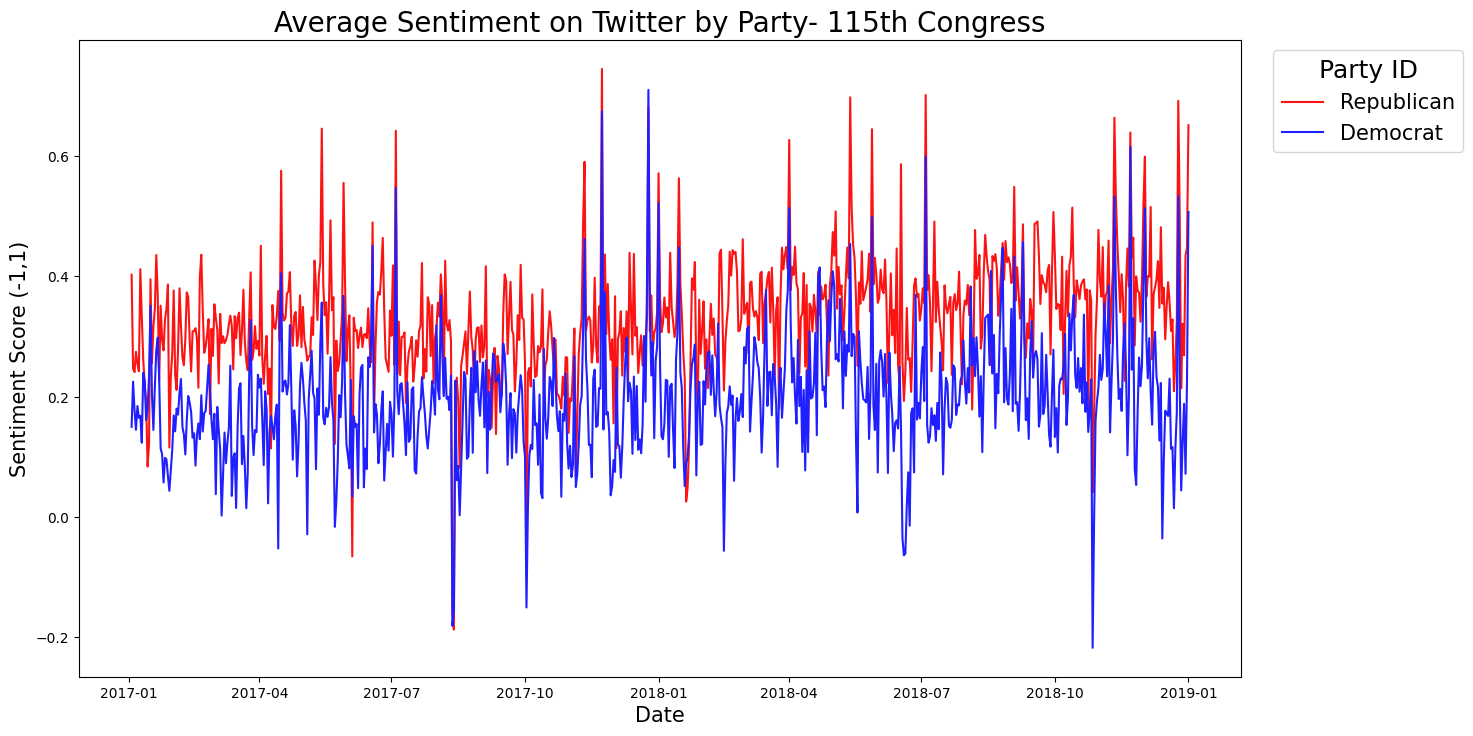

In [175]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 15,8.27

#plt.axhline(y=0, color="grey") 
sns.lineplot(data=tweets_115_merged, x="date", y="vader_score", hue= "party", palette= palette, ci = None)
plt.legend(title='Party ID', loc='upper right', labels=['Republican', 'Democrat'],  bbox_to_anchor=(1.2, 1), title_fontsize=18, fontsize="15")
plt.xlabel("Date", fontsize=15)
plt.ylabel("Sentiment Score (-1,1)", fontsize=15)

plt.title("Average Sentiment on Twitter by Party- 115th Congress", fontsize=20)


plt.savefig('/Users/caranix/Library/CloudStorage/OneDrive-TheOhioStateUniversity/CS MS/legislative tweets analysis/figures/sentiment_115.png', dpi=400)

In [197]:
unique_usernames = tweets_115_merged.username_clean.unique()

In [198]:
len(unique_usernames)

422

In [205]:
np.nansum(tweets_115_merged.groupby(by=["username_clean"]).first()["Democrat"])

207.0

In [206]:
207

207

In [207]:
422-207

215

In [44]:
tweets_116_merged['7day_rolling_avg'] = tweets_116_merged.vader_score.rolling(7).mean()

In [46]:
tweets_116_merged['10day_rolling_avg'] = tweets_116_merged.vader_score.rolling(10).mean()

/var/folders/09/l3m63nj90fg1l2jshjp_hd5w0000gn/T/ipykernel_84433/1734902211.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=tweets_115_merged, x="date", y="vader_score", hue= "party", palette= palette, ci = None)


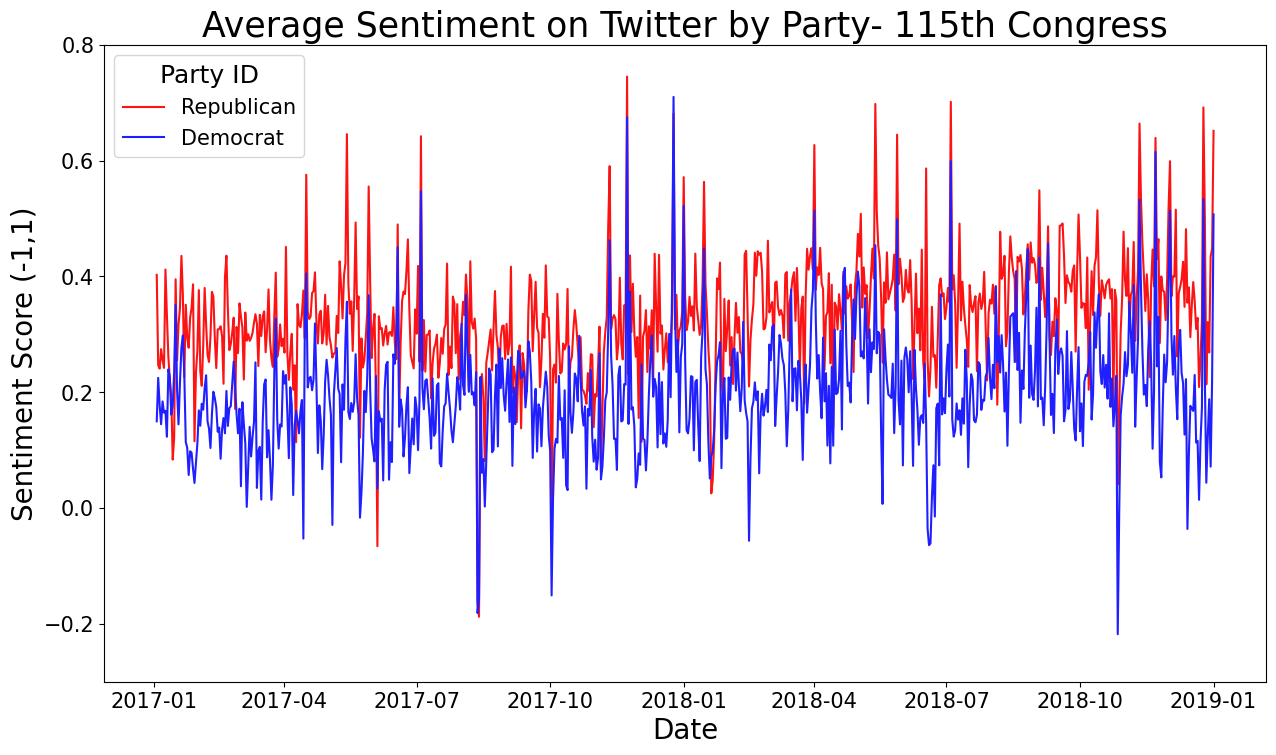

In [181]:
palette = {
    0.0: '#fc1414', #red
    1.0: '#1f1fff', #blue
}

from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 15,8.27

#plt.axhline(y=0, color="grey") 
sns.lineplot(data=tweets_115_merged, x="date", y="vader_score", hue= "party", palette= palette, ci = None)
plt.legend(title='Party ID', loc='upper left', labels=['Republican', 'Democrat'], title_fontsize=18, fontsize="15") #bbox_to_anchor=(1.15, 1)
plt.xlabel("Date", fontsize=20)
plt.ylabel("Sentiment Score (-1,1)", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(-.3,.8)
plt.title("Average Sentiment on Twitter by Party- 115th Congress", fontsize=25)


plt.savefig('/Users/caranix/Library/CloudStorage/OneDrive-TheOhioStateUniversity/CS MS/legislative tweets analysis/figures/sentiment_115.png', dpi=500, bbox_inches="tight")
#v2 = 7dayrolling avg 

In [178]:
# female 
np.mean(tweets_115_merged[tweets_115_merged['Female'] == 1]['vader_score'])

0.20993534497981836

In [179]:
# male 
np.mean(tweets_115_merged[tweets_115_merged['Female'] == 0]['vader_score'])

0.23946453630542824

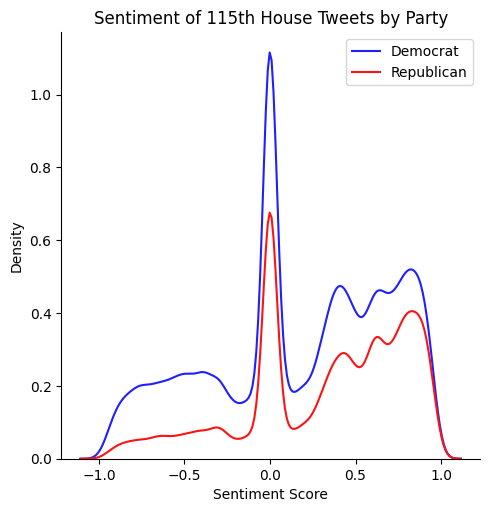

In [177]:
# https://seaborn.pydata.org/generated/seaborn.kdeplot.html
import matplotlib.pyplot as plt

#The units on the density axis are a common source of confusion. 
#While kernel density estimation produces a probability distribution, the height of the curve at each point gives 
#a density, not a probability. A probability can be obtained only by integrating the density across a range. 
#The curve is normalized so that the integral over all possible values is 1, 
#meaning that the scale of the density axis depends on the data values.

#palette ={0: "Red", 1: "Blue"}

sns.displot(data=tweets_115_merged, x="vader_score", hue="party", kind="kde", palette =palette, legend= False)
plt.legend(labels= ['Democrat', 'Republican'])
plt.title("Sentiment of 115th House Tweets by Party")
plt.xlabel("Sentiment Score")



#plt.savefig('/Users/caranix/Library/CloudStorage/OneDrive-TheOhioStateUniversity/CS MS/legislative tweets analysis/figures/115thHousekde.png', dpi=300, bbox_inches='tight')

#ax.legend(labels=["Republican", "Democrat"])
#plt.show(g)



#plt.legend(title='Smoker', loc='upper left', labels=['Hell Yeh', 'Nah Bruh'])
#plt.show(g)


In [ ]:
# descriptive stats for 117th congress- i know this si bad coding rpactice but I needed the #'s 

In [214]:
oms= pd.read_csv("/Users/caranix/Documents/GitHub/CapitolLetters/One Minute Congresional Speech Data/cleaned_transcript_data_117th.csv")

In [221]:
def get_party(text):
    
    return(text.split("-")[0])
    
oms["party_state"]= oms["party_state"].astype("str")
oms["party"] = oms["party_state"].apply(get_party)

In [227]:
sum(oms["party"] =="R")

1485

In [228]:
1485/3094

0.4799612152553329